In [1]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import imblearn as imb
# print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import itertools

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from rdkit import Chem
from rdkit.Chem import Draw
import sys
sys.path.append('../')
# import utils
from sklearn.model_selection import GridSearchCV
from VisUtils import *
from split_data import *
from RF_GSCV import *
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from imblearn.under_sampling import RandomUnderSampler

# Load binding data 

In [3]:
split_path = "/Users/radhi/Desktop/CAPSTONE_DATA/NEK_data_4Berkeley/NEK5" 
train_x_df = pd.read_csv(split_path+"/NEK5_binding_random_fold1_trainX.csv")
train_y_df = pd.read_csv(split_path+"/NEK5_binding_random_fold1_trainY.csv")
test_x_df = pd.read_csv(split_path+"/NEK5_binding_random_fold1_testX.csv")
test_y_df = pd.read_csv(split_path+"/NEK5_binding_random_fold1_testY.csv")

# Undersample 

In [4]:
# # Scale data
x_df = pd.concat([train_x_df, test_x_df])

scaling=StandardScaler()
 
# Use fit and transform method 
scaling.fit(x_df)
Scaled_data=scaling.transform(x_df)
train_x = scaling.transform(train_x_df)
test_x = scaling.transform(test_x_df) 

undersample = RandomUnderSampler()
train_x_temp, train_y_temp = undersample.fit_resample(train_x, train_y_df)
train_x = train_x_temp
train_y = train_y_temp.to_numpy().flatten()
test_y = test_y_df.to_numpy().flatten()


In [5]:
# # back to df for saving 
train_x_df = pd.DataFrame(train_x) 
train_y_df = pd.DataFrame(train_y) 
test_y_df = pd.DataFrame(test_y)
test_x_df = pd.DataFrame(test_x)

train_x_df.to_csv(split_path+'bind_train_x_UNDER.csv', index=False, header=False)
train_y_df.to_csv(split_path+'bind_train_y_UNDER.csv', index=False, header=False) 
test_y_df.to_csv(split_path+'bind_test_y_UNDER.csv', index=False, header=False) 
test_x_df.to_csv(split_path+'bind_test_x_UNDER.csv', index=False, header=False)

train_x_df = pd.read_csv(split_path+'bind_train_x_UNDER.csv')
train_y_df= pd.read_csv(split_path+'bind_train_y_UNDER.csv')
test_x_df= pd.read_csv(split_path+'bind_test_x_UNDER.csv')
test_y_df= pd.read_csv(split_path+'bind_test_y_UNDER.csv')

train_x = train_x_df.to_numpy()
train_y = train_y_df.to_numpy().reshape(-1)
test_x = test_x_df.to_numpy()
test_y = test_y_df.to_numpy().reshape(-1)
train_x.shape, train_y.shape, test_x.shape, test_y.shape



((153, 306), (153,), (247, 306), (247,))

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.599, precision: 0.144, recall: 0.800, sensitivity: 0.800, specificity: 0.581


<Figure size 600x400 with 0 Axes>

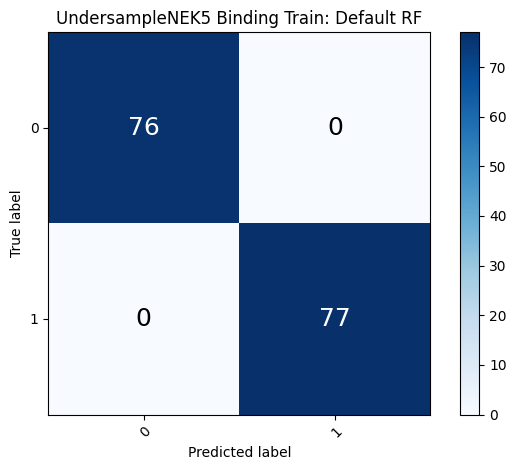

<Figure size 600x400 with 0 Axes>

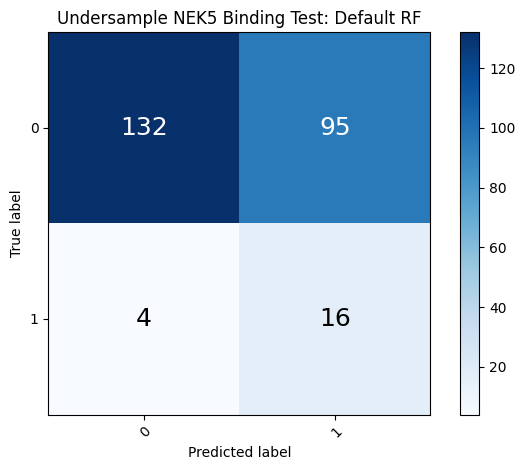

In [6]:
rf_basic100estUNDER = rf_models(train_x, train_y, test_x, test_y, 'basic RF', {}, 'binding')
plot_confusion_matrix(train_y, rf_basic100estUNDER['train_pred'], ['0','1'], title='UndersampleNEK5 Binding Train: Default RF')
plot_confusion_matrix(test_y, rf_basic100estUNDER['test_pred'], ['0','1'], title='Undersample NEK5 Binding Test: Default RF')

# Reduced param grid for grid search - RUN IN BASH SCRIPT 

In [7]:
param_grid = {
    'n_estimators': np.linspace(100, 2000, 3, dtype = int),
    'max_depth': [20, 100, 200, 220],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 5],
    'criterion': ['gini','entropy']
}

In [8]:
save_file = 'atom_nek5bindUNDER_rf_basic_best.pkl'
rf_basicbestUNDER = find_best_models(train_x, train_y, test_x, test_y, 'basic RF', {}, param_grid,  save_file, 2)

TRAIN: accuracy: 0.987, precision: 1.000, recall: 0.974, sensitivity: 0.974, specificity: 1.000
TEST: accuracy: 0.583, precision: 0.139, recall: 0.800, sensitivity: 0.800, specificity: 0.564


TRAIN: accuracy: 0.987, precision: 1.000, recall: 0.974, sensitivity: 0.974, specificity: 1.000
TEST: accuracy: 0.583, precision: 0.139, recall: 0.800, sensitivity: 0.800, specificity: 0.564


<Figure size 600x400 with 0 Axes>

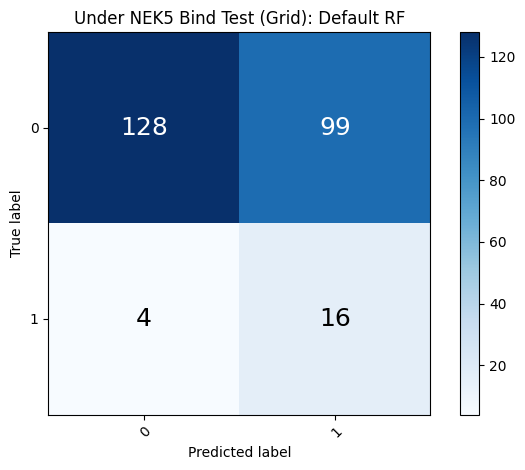

In [10]:
with open(save_file, 'wb') as f:
    pickle.dump(rf_basicbestUNDER['best_model'], f)

save_file = 'atom_nek5bindUNDER_rf_basic_best.pkl'
with open(save_file, 'rb') as f: 
    rf_basicbestUNDER = pickle.load(f) 
gridresults1 = rf_results2(rf_basicbestUNDER, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, gridresults1['test_pred'], ['0','1'], title='Under NEK5 Bind Test (Grid): Default RF')

# Basic RF + classweight balanced 

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.591, precision: 0.142, recall: 0.800, sensitivity: 0.800, specificity: 0.573


<Figure size 600x400 with 0 Axes>

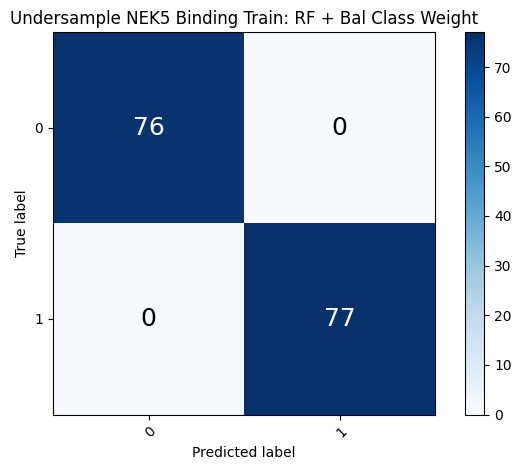

<Figure size 600x400 with 0 Axes>

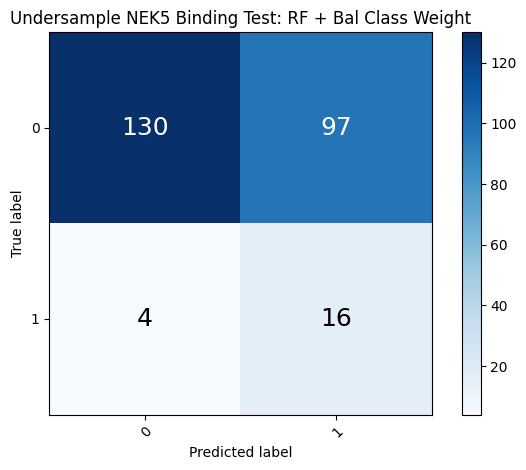

In [11]:
brf_model_BCW_UNDER = rf_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {}, 'binding')
plot_confusion_matrix(train_y, brf_model_BCW_UNDER['train_pred'], ['0','1'], title='Undersample NEK5 Binding Train: RF + Bal Class Weight')
plot_confusion_matrix(test_y, brf_model_BCW_UNDER['test_pred'], ['0','1'], title='Undersample NEK5 Binding Test: RF + Bal Class Weight')

In [14]:
save_file2 = 'atom_nek5bindUNDER_rf_basicBCW_best.pkl'
rf_basicBCWbestUNDER = find_best_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {}, param_grid,  save_file2, 2)

with open(save_file2, 'wb') as f:
    pickle.dump(rf_basicBCWbestUNDER['best_model'], f)



TRAIN: accuracy: 0.954, precision: 0.949, recall: 0.961, sensitivity: 0.961, specificity: 0.947
TEST: accuracy: 0.619, precision: 0.144, recall: 0.750, sensitivity: 0.750, specificity: 0.608


TRAIN: accuracy: 0.954, precision: 0.949, recall: 0.961, sensitivity: 0.961, specificity: 0.947
TEST: accuracy: 0.619, precision: 0.144, recall: 0.750, sensitivity: 0.750, specificity: 0.608


<Figure size 600x400 with 0 Axes>

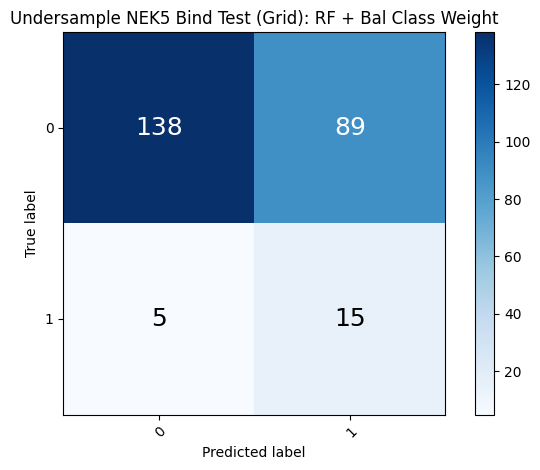

In [15]:
save_file2 = 'atom_nek5bindUNDER_rf_basicBCW_best.pkl'
with open(save_file2, 'rb') as f: 
    rf_basicBCWbestUNDER = pickle.load(f) 

gridresults2 = rf_results2(rf_basicBCWbestUNDER, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, gridresults2['test_pred'], ['0','1'], title='Undersample NEK5 Bind Test (Grid): RF + Bal Class Weight')

# Balanced Random Forest Classifier

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.567, precision: 0.134, recall: 0.800, sensitivity: 0.800, specificity: 0.546


<Figure size 600x400 with 0 Axes>

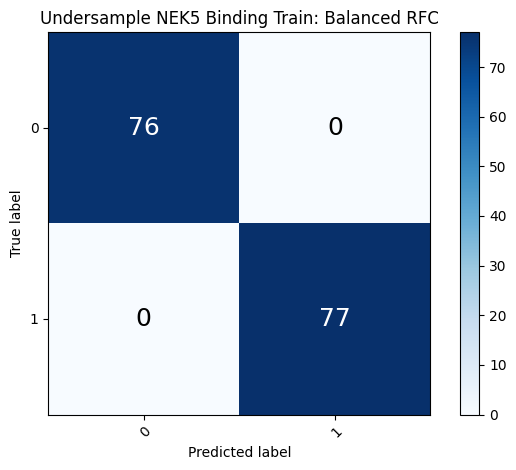

<Figure size 600x400 with 0 Axes>

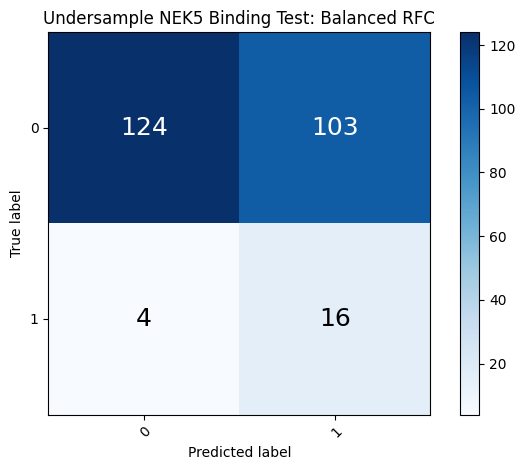

In [16]:
brf_modelUNDER = rf_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {}, 'binding')
plot_confusion_matrix(train_y, brf_modelUNDER['train_pred'], ['0','1'], title='Undersample NEK5 Binding Train: Balanced RFC')
plot_confusion_matrix(test_y, brf_modelUNDER['test_pred'], ['0','1'], title='Undersample NEK5 Binding Test: Balanced RFC')

# Try BRFC with balanced class weight & bootstrap

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.603, precision: 0.158, recall: 0.900, sensitivity: 0.900, specificity: 0.577


<Figure size 600x400 with 0 Axes>

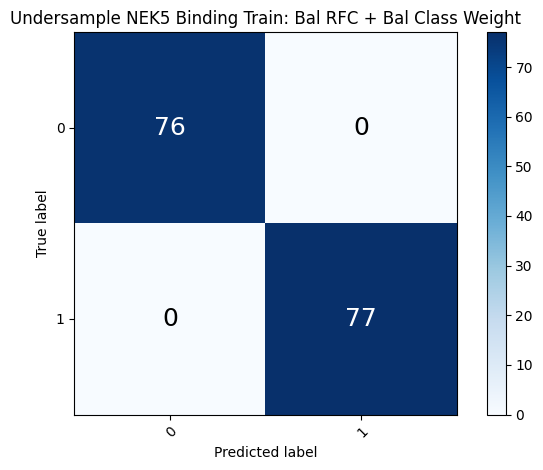

<Figure size 600x400 with 0 Axes>

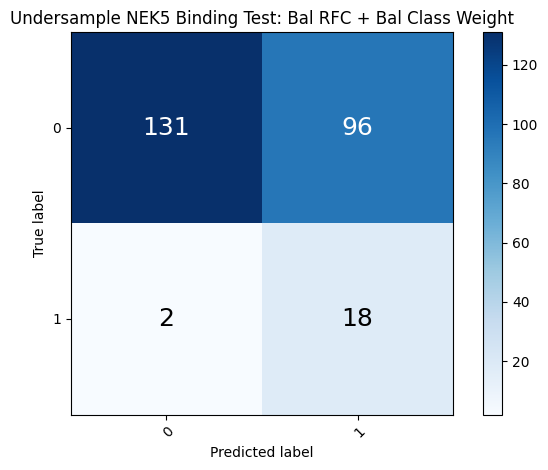

In [19]:
brf_modelCWB_UNDER = rf_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {'class_weight':'balanced', 'bootstrape':'True'}, 'binding')
plot_confusion_matrix(train_y, brf_modelCWB_UNDER['train_pred'], ['0','1'], title='Undersample NEK5 Binding Train: Bal RFC + Bal Class Weight')
plot_confusion_matrix(test_y, brf_modelCWB_UNDER['test_pred'], ['0','1'], title='Undersample NEK5 Binding Test: Bal RFC + Bal Class Weight')